In [32]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
from sklearn import preprocessing


In [33]:
file_path = 'dataset/cleaned_data.csv'

# Load the dataset
data_fillmean = pd.read_csv(file_path)

In [34]:
# Select numeric columns to scale
numeric_columns = ['sqft_living', 'bathrooms', 'bedrooms', 'sqft_above', 'floors']

# Apply Standard Scaler
standard_scaler = StandardScaler()
data_standard_scaled = standard_scaler.fit_transform(data_fillmean[numeric_columns])
data_standard_scaled = pd.DataFrame(data_standard_scaled, columns=numeric_columns)

# Apply Robust Scaler
robust_scaler = RobustScaler()
data_robust_scaled = robust_scaler.fit_transform(data_fillmean[numeric_columns])
data_robust_scaled = pd.DataFrame(data_robust_scaled, columns=numeric_columns)

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
data_minmax_scaled = minmax_scaler.fit_transform(data_fillmean[numeric_columns])
data_minmax_scaled = pd.DataFrame(data_minmax_scaled, columns=numeric_columns)

# Prepare datasets for model fitting
datasets = {
    'Original': data_fillmean,
    'Standard Scaled': data_standard_scaled,
    'Robust Scaled': data_robust_scaled,
    'MinMax Scaled': data_minmax_scaled
}


Original Data Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     553.2
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        03:09:08   Log-Likelihood:                -57010.
No. Observations:                4255   AIC:                         1.140e+05
Df Residuals:                    4249   BIC:                         1.141e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         1.66e+0

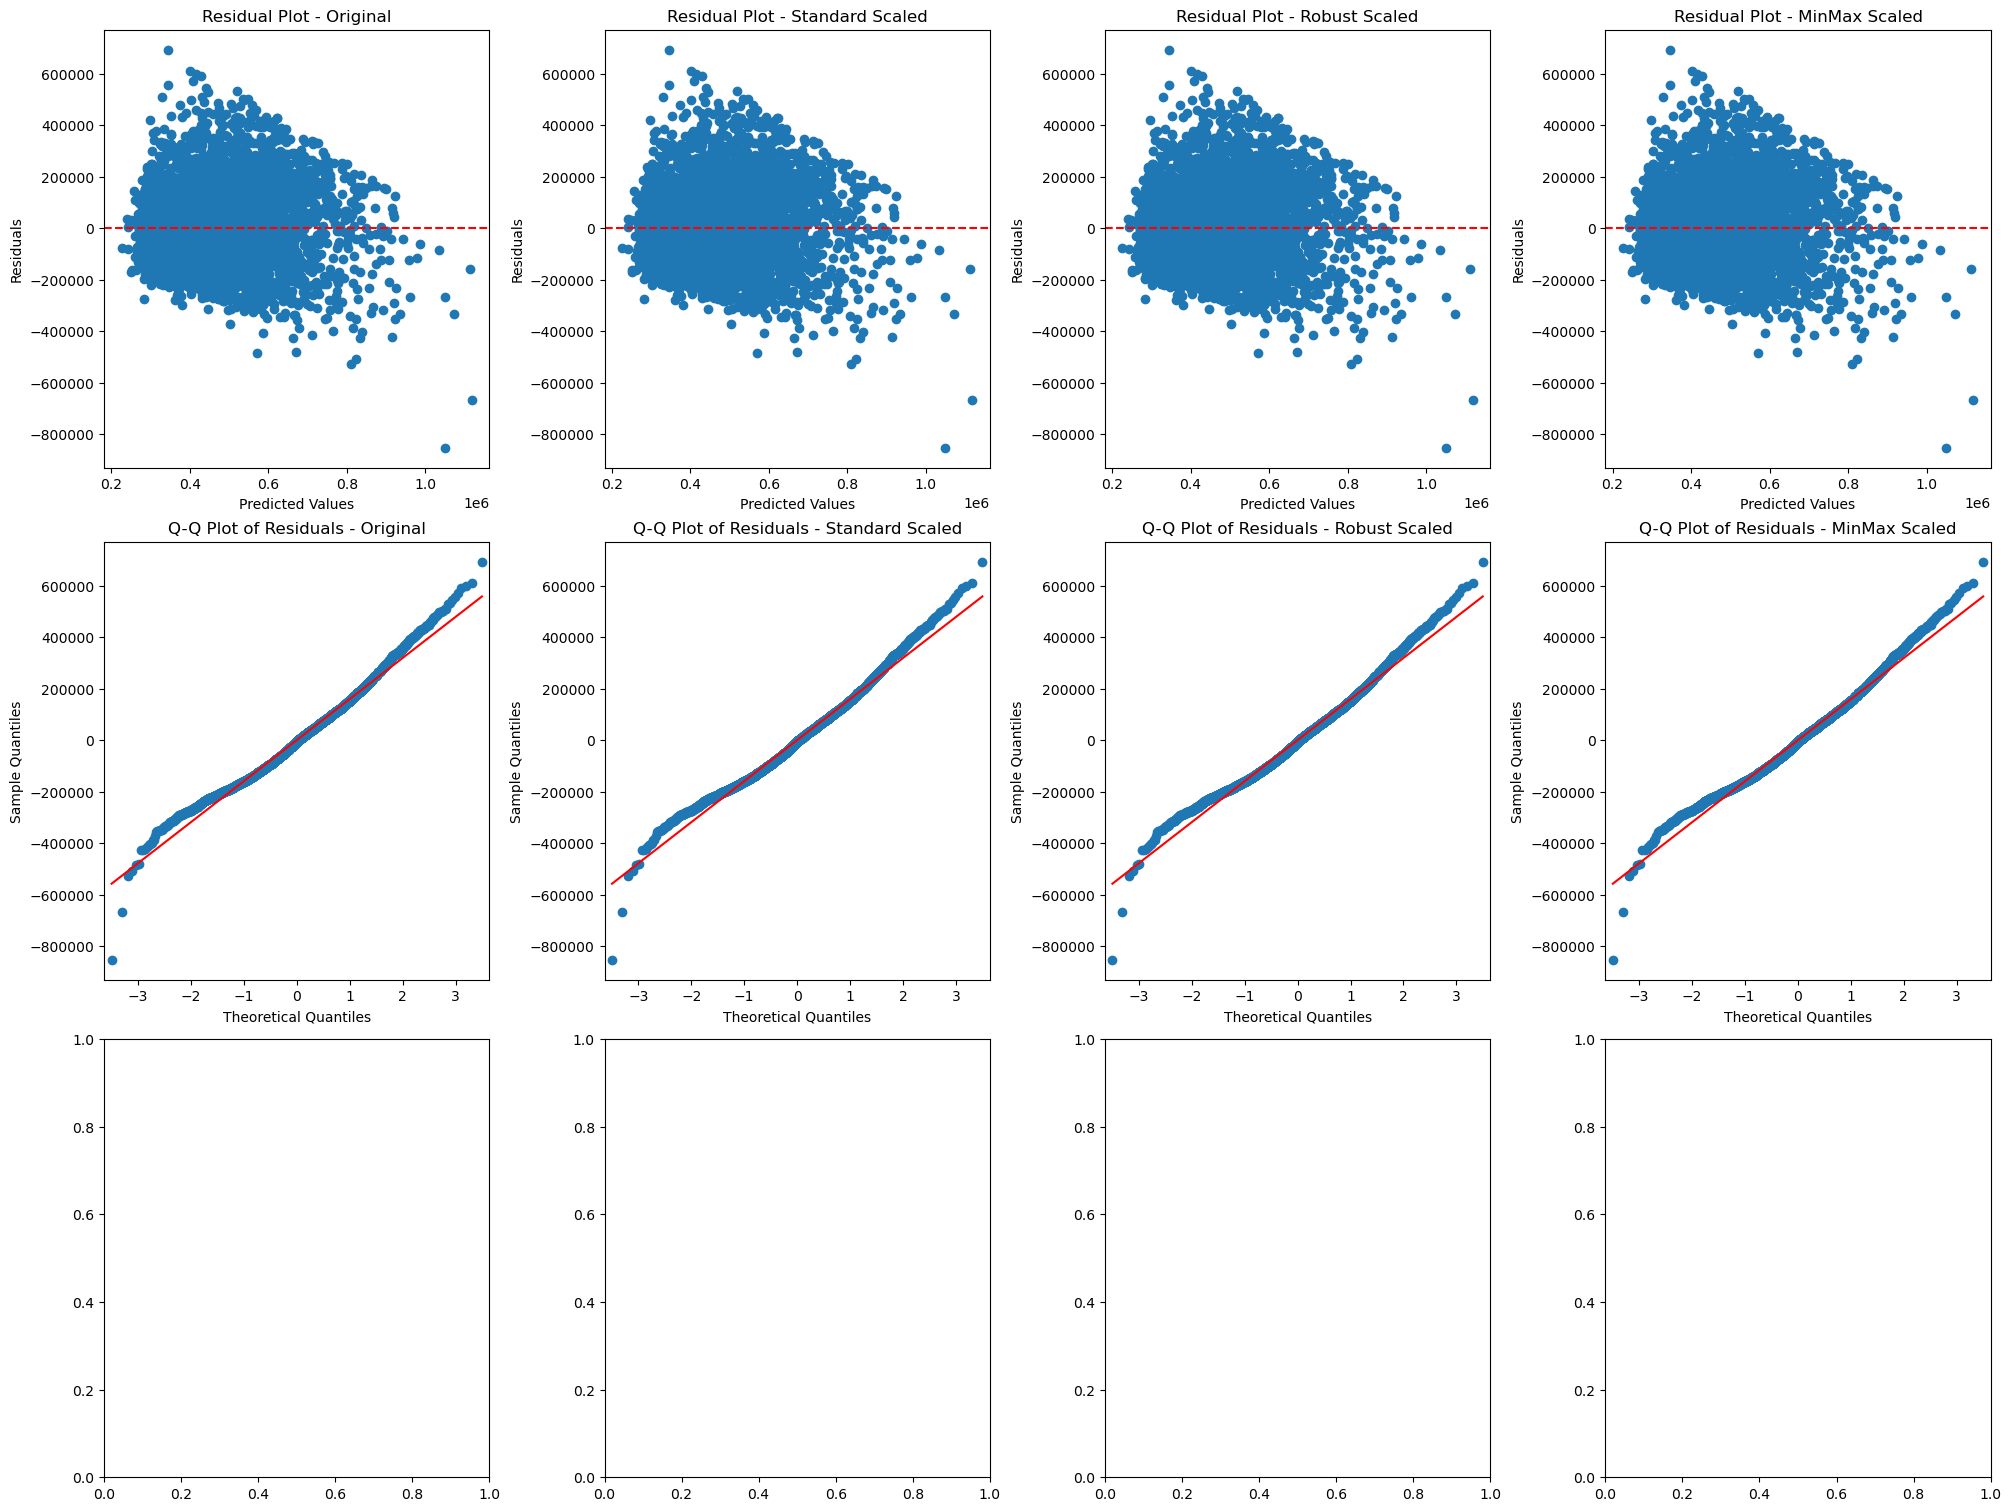

In [35]:
# Initialize figure for plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), constrained_layout=True)

for idx, (name, dataset) in enumerate(datasets.items()):
    X = dataset[numeric_columns]
    y = data_fillmean['price']  # Price remains unscaled to maintain interpretability of the model output

    # Adding a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Fitting the OLS model
    model = sm.OLS(y, X).fit()

    # Print the model summary
    print(f"{name} Data Model Summary:")
    print(model.summary())
    print("\n")

    # Residual plot
    axs[0, idx].scatter(model.predict(), model.resid)
    axs[0, idx].axhline(y=0, color='red', linestyle='--')
    axs[0, idx].set_xlabel('Predicted Values')
    axs[0, idx].set_ylabel('Residuals')
    axs[0, idx].set_title(f'Residual Plot - {name}')

    # Q-Q plot for normality
    sm.qqplot(model.resid, line='s', ax=axs[1, idx])
    axs[1, idx].set_title(f"Q-Q Plot of Residuals - {name}")


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Selecting features to check for multicollinearity
features = data_fillmean[['sqft_living', 'bathrooms', 'bedrooms', 'sqft_above', 'floors']]
features = add_constant(features)  # adding a constant column for intercept

# Calculating VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns

print(vif)

   VIF Factor     features
0   21.046624        const
1    5.982870  sqft_living
2    2.607681    bathrooms
3    1.637180     bedrooms
4    4.968378   sqft_above
5    1.803279       floors


Explanation:

Removing sqft_above: This step is crucial to reduce the multicollinearity which is affecting your model's accuracy and the interpretation of its coefficients.


Normalization: 

he remaining features are scaled using MinMaxScaler which transforms the data into the range [0, 1]. This is especially useful for regression models and other algorithms that are sensitive to the scale of input features.

In [37]:
data_fillmean.drop('sqft_above', axis=1, inplace=True)

# Selecting the remaining features after removing 'sqft_above'
features_to_scale = ['sqft_living', 'bathrooms', 'bedrooms', 'floors']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
data_fillmean[features_to_scale] = scaler.fit_transform(data_fillmean[features_to_scale])

# Check the first few rows of the normalized data
print(data_fillmean[features_to_scale].head())

   sqft_living  bathrooms  bedrooms  floors
0     0.173524       0.15     0.250     0.2
1     0.279070       0.25     0.250     0.0
2     0.291592       0.30     0.250     0.0
3     0.280859       0.35     0.375     0.0
4     0.091234       0.05     0.125     0.0


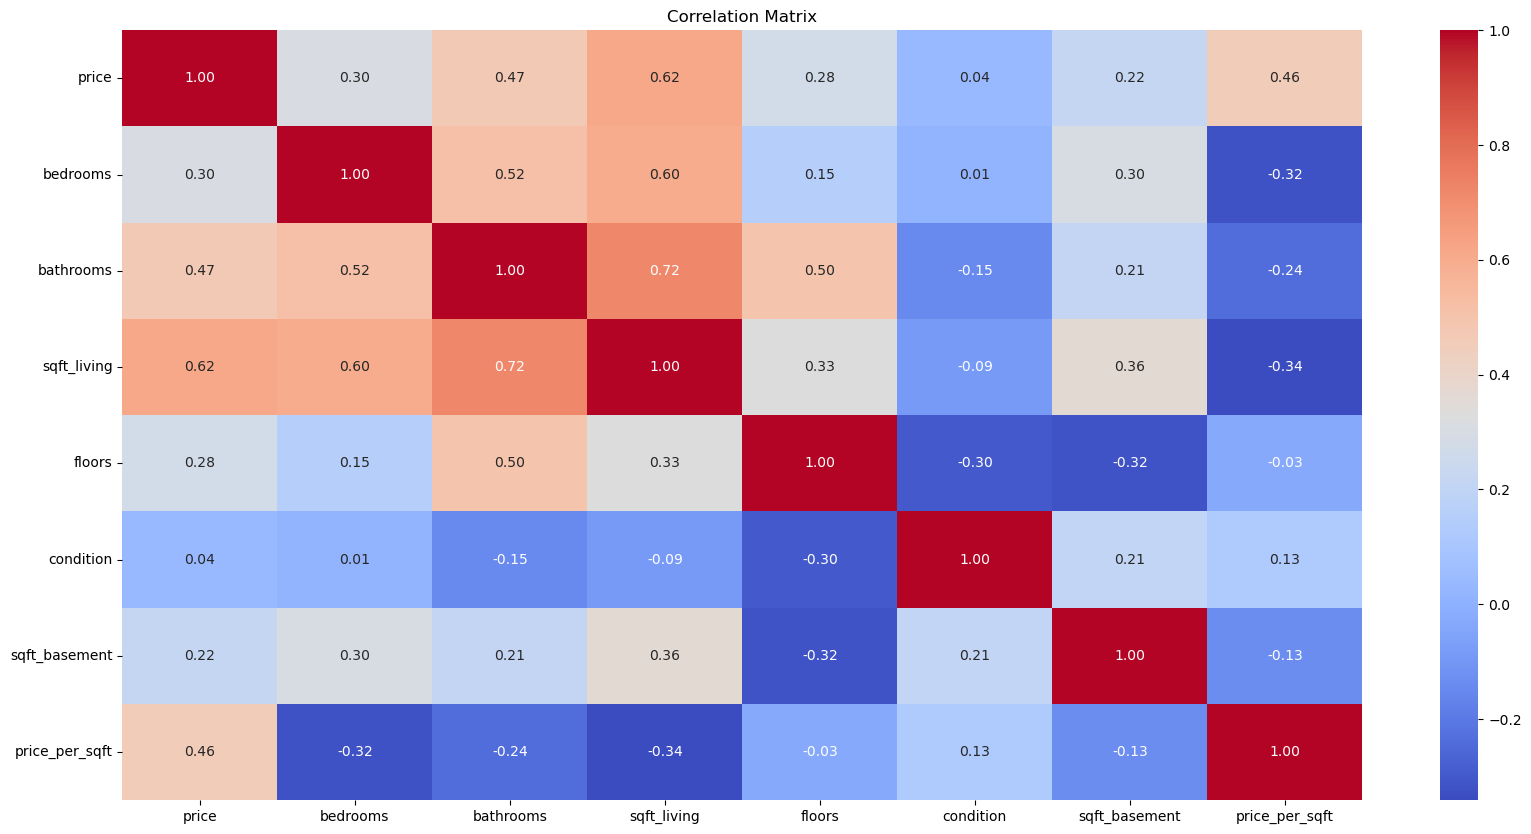

In [38]:
# Save the cleaned dataset
data_fillmean.to_csv('dataset/normalised_data.csv', index=False)
numerical_columns = data_fillmean.select_dtypes(include=['number']).columns
data_numeric = data_fillmean[numerical_columns]

# Creating heatmap for correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()